In [1]:
# Kaggle Energy Disaggregation — fast baseline
# Requirements: pandas, numpy, scipy
# Save as disagg_baseline.py or run in a notebook cell.

import pandas as pd
import numpy as np
from scipy.optimize import nnls

In [2]:
# =========================
# Config / hyperparameters
# =========================
NIGHT_HOURS = [2, 3, 4, 5]
BASELINE_QUANTILE = 0.15      # 10–20% works; tune if needed
EV_SPIKE_THRESH_KWH = 1.2     # "high evening consumption" spikes (per hour) above baseline
EV_MIN_EVENT_HOURS = 2        # require at least this many spike hours in evening window on a day
EV_MIN_EVENT_DAYS = 3         # min days with events to flag EV ownership
EV_EVENING_HOURS_WD = [20,21,22,23,0,1,2,3]   # weekday EV window
EV_MIDDAY_HOURS_WE = [11,12,13,14,15,16]  # weekend EV window
HEAT_MORNING_HOURS = [6,7,8,9]
HEAT_EVENING_HOURS = [17,18,19,20,21]
OTHER_MORNING_HOURS = [7,8,9]
OTHER_EVENING_HOURS = [17,18,19,20]

In [3]:
# ================
# Load & prepare
# ================
df = pd.read_csv('kaggle_clustering_student_version.csv')
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = df["timestamp"].dt.date
df["hour"] = df["timestamp"].dt.hour
df["dow"] = df["timestamp"].dt.dayofweek  # 0=Mon,...,6=Sun
df["is_weekend"] = df["dow"] >= 5

In [4]:
df.head(10)

,kaggle_id,household_id,timestamp,consumption_kWh,date,hour,dow,is_weekend
0,0_2024-03-01 00,0,2024-03-01 00:00:00,0.2590,2024-03-01,0,4,False
1,0_2024-03-01 01,0,2024-03-01 01:00:00,0.0648,2024-03-01,1,4,False
2,0_2024-03-01 02,0,2024-03-01 02:00:00,0.0644,2024-03-01,2,4,False
3,0_2024-03-01 03,0,2024-03-01 03:00:00,0.0661,2024-03-01,3,4,False
4,0_2024-03-01 04,0,2024-03-01 04:00:00,0.1306,2024-03-01,4,4,False
5,0_2024-03-01 05,0,2024-03-01 05:00:00,0.0721,2024-03-01,5,4,False
6,0_2024-03-01 06,0,2024-03-01 06:00:00,0.0964,2024-03-01,6,4,False
7,0_2024-03-01 07,0,2024-03-01 07:00:00,0.0880,2024-03-01,7,4,False
8,0_2024-03-01 08,0,2024-03-01 08:00:00,0.0602,2024-03-01,8,4,False
9,0_2024-03-01 09,0,2024-03-01 09:00:00,0.0864,2024-03-01,9,4,False


In [5]:
# ===========================
# Always-on (per household)
# ===========================
def estimate_always_on_per_household(pdf: pd.DataFrame) -> float:
    # Use low quantile of night hours across all days as constant baseline
    night = pdf.loc[pdf["hour"].isin(NIGHT_HOURS), "consumption_kWh"]
    if len(night) < 5:
        night = pdf["consumption_kWh"]  # fallback
    baseline = float(np.quantile(night.values, BASELINE_QUANTILE))
    # keep small positive minimum
    return max(baseline, 0.01)

always_on_map = df.groupby("household_id").apply(estimate_always_on_per_household).to_dict()
df["always_on_kWh"] = df["household_id"].map(always_on_map)

# Residual after removing always-on
df["residual_kWh"] = (df["consumption_kWh"] - df["always_on_kWh"]).clip(lower=0.0)


/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_51518/3678772744.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  always_on_map = df.groupby("household_id").apply(estimate_always_on_per_household).to_dict()


In [6]:
df["always_on_kWh"].describe()

count    441600.000000
mean          0.205292
std           0.080804
min           0.063250
25%           0.148336
50%           0.199585
75%           0.252282
max           0.487075
Name: always_on_kWh, dtype: float64

In [7]:
# Residual after removing always-on
df["residual_kWh"] = (df["consumption_kWh"] - df["always_on_kWh"]).clip(lower=0.0)

In [8]:
# =================================
# Coldness proxy (heating intensity)
# =================================
# Proxy: systemwide daily mean residual (higher => colder day → more heating)
daily_system_mean = (
    df.groupby("date")["residual_kWh"]
      .mean()
      .rename("system_resid_mean")
      .to_frame()
)
# Normalize to [0,1]
min_m = daily_system_mean["system_resid_mean"].min()
max_m = daily_system_mean["system_resid_mean"].max()
daily_system_mean["coldness_idx"] = 0.0 if max_m == min_m else (
    (daily_system_mean["system_resid_mean"] - min_m) / (max_m - min_m)
)
df = df.merge(daily_system_mean[["coldness_idx"]], left_on="date", right_index=True, how="left")

In [9]:
# --- after you compute df["residual_kWh"] and coldness_idx ---

# daily residual energy per household
hh_day = (df.groupby(["household_id","date"])["residual_kWh"].sum()
            .rename("resid_day").to_frame()
            .merge(df.groupby("date")["coldness_idx"].first(), left_on="date", right_index=True))

# per-household correlation of residual vs coldness
heat_corr = (hh_day.reset_index()
             .groupby("household_id")
             .apply(lambda t: t["resid_day"].corr(t["coldness_idx"]))
             .fillna(0.0)
             .rename("heat_corr"))

# classify heating owners (thresholds you can tune: 0.25–0.40)
HEAT_CORR_THRESH = 0.30
is_heat_owner = (heat_corr >= HEAT_CORR_THRESH).to_dict()
df["is_heat_owner"] = df["household_id"].map(is_heat_owner)

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_51518/161049425.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda t: t["resid_day"].corr(t["coldness_idx"]))


In [10]:
# ===========================
# 24h templates (unit-norm)
# ===========================
def unit(v):
    v = np.array(v, dtype=float)
    s = v.sum()
    return v / s if s > 0 else np.ones_like(v)/len(v)

def build_heating_profile(is_weekend: bool):
    v = np.zeros(24, dtype=float)
    for h in HEAT_MORNING_HOURS: v[h] += 1.0
    for h in HEAT_EVENING_HOURS: v[h] += 1.2  # evening slightly stronger
    if is_weekend:
        # weekend: reduced peaks, higher baseline
        v = 0.7 * v + 0.3  # soften + lift
    return unit(v)

def build_ev_profile(is_weekend: bool):
    v = np.zeros(24, dtype=float)
    hrs = EV_MIDDAY_HOURS_WE if is_weekend else EV_EVENING_HOURS_WD
    for h in hrs: v[h] += 1.0
    # EV tends to be spiky: concentrate mass
    return unit(v)

def build_other_profile(is_weekend: bool):
    v = np.zeros(24, dtype=float)
    for h in OTHER_MORNING_HOURS: v[h] += 1.0
    for h in OTHER_EVENING_HOURS: v[h] += 1.0
    if is_weekend:
        # weekend: peaks disappear, steadier moderate
        v = 0.4 * v + 0.6
    return unit(v)

HEAT_WD = build_heating_profile(False)
HEAT_WE = build_heating_profile(True)
EV_WD   = build_ev_profile(False)
EV_WE   = build_ev_profile(True)
OTH_WD  = build_other_profile(False)
OTH_WE  = build_other_profile(True)

In [11]:
# ======================================
# EV owner detection (per household)
# ======================================
def ev_owner_flag(pdf, baseline):
    # use weekday evening residuals only for thresholding (strongest signal)
    wd = pdf[~pdf["is_weekend"]]
    resid = (wd.set_index("hour")["residual_kWh"]
               .loc[[20,21,22,23,0,1]].dropna())  # evening window across midnight
    if resid.empty:
        return False
    # threshold: baseline + P90 of that household's evening residuals
    thr = baseline + np.percentile(resid, 90)
    # count "event days": hours > threshold on a day
    events_per_day = (pdf.groupby("date")
        .apply(lambda g: ((g.set_index("hour")["residual_kWh"]
                            .reindex([20,21,22,23,0,1]).fillna(0)
                           ) > thr).sum() >= 2).sum())
    return events_per_day >= 3  # tune 2–4

ev_owner = {}
for hid, pdf in df.groupby("household_id"):
    ev_owner[hid] = ev_owner_flag(pdf, always_on_map[hid])

df["is_ev_owner"] = df["household_id"].map(ev_owner)

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_51518/2808410491.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ((g.set_index("hour")["residual_kWh"]
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_51518/2808410491.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ((g.set_index("hour")["residual_kWh"]
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipy

In [12]:
# ======================================
# Fit per household-day via NNLS on 24h
# ======================================
def fit_day_components(day_df: pd.DataFrame, baseline: float, is_ev_owner: bool):
    """
    Patch: carve out EV spikes first, then fit Heating + Other via NNLS on remainder.
    Keeps everything else as in your good baseline.
    """
    # --- prep
    is_weekend = bool(day_df["is_weekend"].iloc[0])
    H = HEAT_WE if is_weekend else HEAT_WD
    O = OTH_WE  if is_weekend else OTH_WD
    # (keep your previous heating scaling if you like; here I keep your original to avoid oversteer)
    cold = float(day_df["coldness_idx"].iloc[0])
    H_scaled = H * (0.4 + 0.6 * cold)

    # target vectors
    y_total = day_df.set_index("hour")["consumption_kWh"].reindex(range(24)).values
    y_resid = (y_total - baseline).clip(min=0.0)  # residual after always-on
    hours = np.arange(24)

    # ---------------------------
    # 1) EV spike pre-allocation
    # ---------------------------
    ev_pre = np.zeros(24, dtype=float)
    if is_ev_owner:
        ev_window = (EV_MIDDAY_HOURS_WE if is_weekend else EV_EVENING_HOURS_WD)
        # per-day, per-household threshold from the residual in the EV window
        window_vals = np.array([y_resid[h] for h in ev_window], dtype=float)
        if np.isfinite(window_vals).any():
            # percentile threshold relative to *this day* and household scale
            thr = np.percentile(window_vals, 85)  # try 80–90; 85 is a good start
            # add a small margin above baseline so flat evenings don't trigger
            thr = max(thr, 1.2)  # keep your earlier 1.2 kWh/h as a floor
            for h in ev_window:
                excess = y_resid[h] - thr
                if excess > 0:
                    ev_pre[h] = excess
            # cap to residual to avoid numerical issues
            ev_pre = np.minimum(ev_pre, y_resid)
            # reduce residual for the NNLS step
            y_resid = np.maximum(y_resid - ev_pre, 0.0)

    # ------------------------------------------
    # 2) NNLS for Heating + Other on the remainder
    # ------------------------------------------
    from scipy.optimize import nnls
    X = np.vstack([H_scaled, O]).T  # columns: heating, other
    # Safety for missing hours / NaNs (shouldn't happen, but better safe)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    y = np.nan_to_num(y_resid, nan=0.0, posinf=0.0, neginf=0.0)

    a, _ = nnls(X, y)
    heating = a[0] * (H_scaled / (H_scaled.sum() + 1e-12)) * y.sum()
    other   = a[1] * (O       / (O.sum()       + 1e-12)) * y.sum()

    # Per-hour rescale so (baseline + heating + other + ev_pre) matches total exactly
    var_stack = np.vstack([heating, other]).T
    var_sum = var_stack.sum(axis=1) + ev_pre
    desired_var = (y_total - baseline).clip(min=0.0)
    scale = np.divide(desired_var, var_sum, out=np.ones_like(desired_var), where=var_sum>1e-9)

    heating = np.clip(heating * scale, 0.0, None)
    other   = np.clip(other   * scale, 0.0, None)
    ev_out  = np.clip(ev_pre  * scale, 0.0, None)  # keep EV carved shape but rescaled with others

    # Final tiny rebalance into "other" to kill float noise
    recon = baseline + heating + ev_out + other
    fix = (y_total - recon)
    other = np.clip(other + fix, 0.0, None)

    return pd.DataFrame({
        "hour": range(24),
        "heating_kWh": heating,
        "ev_kWh": ev_out,
        "always_on_kWh": np.full(24, baseline),
        "other_kWh": other,
    })

# Apply per household-day
pieces = []
for (hid, day), g in df.groupby(["household_id", "date"]):
    baseline = always_on_map[hid]
    evflag = bool(ev_owner[hid])
    heatflag = bool(is_heat_owner.get(hid, False))  # <- new line: get from dictionary
    comp = fit_day_components(g, baseline, is_ev_owner=bool(ev_owner[hid]))    
    comp["household_id"] = hid
    comp["date"] = day
    pieces.append(comp)

pred = pd.concat(pieces, ignore_index=True)

# Merge back to timestamps
pred["timestamp"] = pd.to_datetime(pred["date"].astype(str)) + pd.to_timedelta(pred["hour"], unit="h")
pred["kaggle_id"] = pred["household_id"].astype(str) + "_" + pred["timestamp"].dt.strftime("%Y-%m-%d %H")

# Order + select columns
submit = pred[[
    "kaggle_id", "heating_kWh", "ev_kWh", "always_on_kWh", "other_kWh"
]].sort_values("kaggle_id").reset_index(drop=True)

# Basic sanity checks
def sanity_checks(df_raw, df_pred):
    # 1) Non-negativity
    assert (df_pred[["heating_kWh","ev_kWh","always_on_kWh","other_kWh"]] >= -1e-7).all().all()
    # 2) Sum equals original
    merged = df_raw.merge(
        df_pred, on="kaggle_id", how="left"
    )
    approx = merged[["heating_kWh","ev_kWh","always_on_kWh","other_kWh"]].sum(axis=1).values
    diff = np.abs(approx - merged["consumption_kWh"].values)
    print("Mean absolute balance error:", diff.mean())
    print("95th pct balance error:", np.quantile(diff, 0.95))
    # 3) Reasonable shares
    shares = approx / (merged["consumption_kWh"].values + 1e-9)
    print("Share mean:", shares.mean())

# Build kaggle_id in original to check sum
df["kaggle_id"] = df["household_id"].astype(str) + "_" + df["timestamp"].dt.strftime("%Y-%m-%d %H")

sanity_checks(df[["kaggle_id","consumption_kWh"]].copy(), submit)

# Write submission
submit.to_csv("submission_disagg_baseline.csv", index=False)
print("Wrote submission_disagg_baseline.csv with", len(submit), "rows.")

Mean absolute balance error: 0.006518871988224644
95th pct balance error: 0.05201499999999998
Share mean: 100621.30512996487
Wrote submission_disagg_baseline.csv with 441600 rows.


In [13]:
submit

,kaggle_id,heating_kWh,ev_kWh,always_on_kWh,other_kWh
0,0_2024-03-01 00,0.00000,0.0,0.09066,0.16834
1,0_2024-03-01 01,0.00000,0.0,0.09066,0.00000
2,0_2024-03-01 02,0.00000,0.0,0.09066,0.00000
3,0_2024-03-01 03,0.00000,0.0,0.09066,0.00000
4,0_2024-03-01 04,0.00000,0.0,0.09066,0.03994
...,...,...,...,...,...
441595,9_2024-05-31 19,0.43932,0.0,0.15388,0.00000
441596,9_2024-05-31 20,0.41652,0.0,0.15388,0.00000
441597,9_2024-05-31 21,0.73822,0.0,0.15388,0.00000
441598,9_2024-05-31 22,0.00000,0.0,0.15388,0.75562


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")

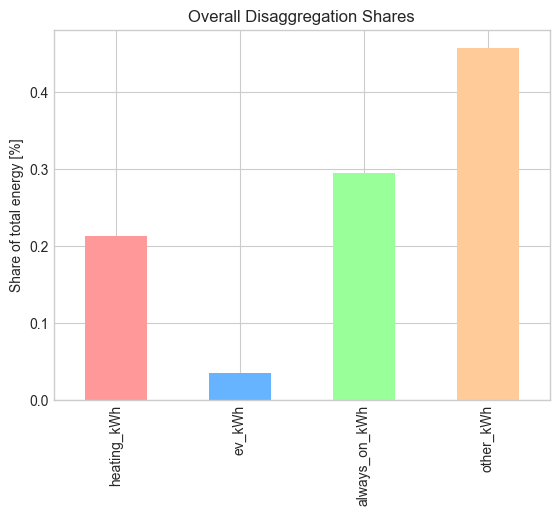

In [15]:
component_totals = submit[["heating_kWh","ev_kWh","always_on_kWh","other_kWh"]].sum()
component_share = component_totals / component_totals.sum()

component_share.plot(kind="bar", color=["#ff9999","#66b3ff","#99ff99","#ffcc99"])
plt.ylabel("Share of total energy [%]")
plt.title("Overall Disaggregation Shares")
plt.show()

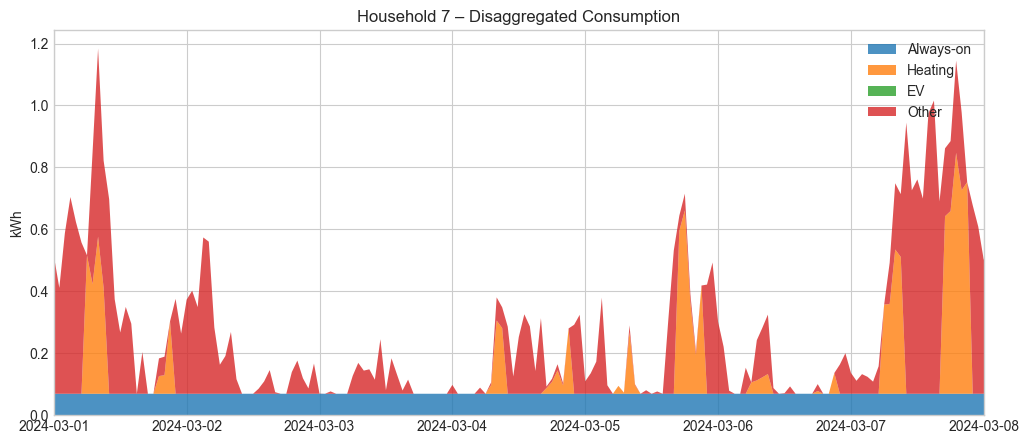

In [16]:
hh = np.random.choice(submit["kaggle_id"].str.split("_").str[0].unique())
mask = submit["kaggle_id"].str.startswith(hh + "_")
hh_data = submit[mask].copy()
hh_data["timestamp"] = pd.to_datetime(hh_data["kaggle_id"].str.split("_").str[1])
hh_data = hh_data.sort_values("timestamp")

# Plot stacked area
plt.figure(figsize=(12,5))
plt.stackplot(
    hh_data["timestamp"], 
    hh_data["always_on_kWh"], 
    hh_data["heating_kWh"],
    hh_data["ev_kWh"], 
    hh_data["other_kWh"],
    labels=["Always-on", "Heating", "EV", "Other"],
    alpha=0.8
)
plt.legend(loc="upper right")
plt.title(f"Household {hh} – Disaggregated Consumption")
plt.ylabel("kWh")
plt.xlim(hh_data["timestamp"].min(), hh_data["timestamp"].min() + pd.Timedelta("7D"))
plt.show()

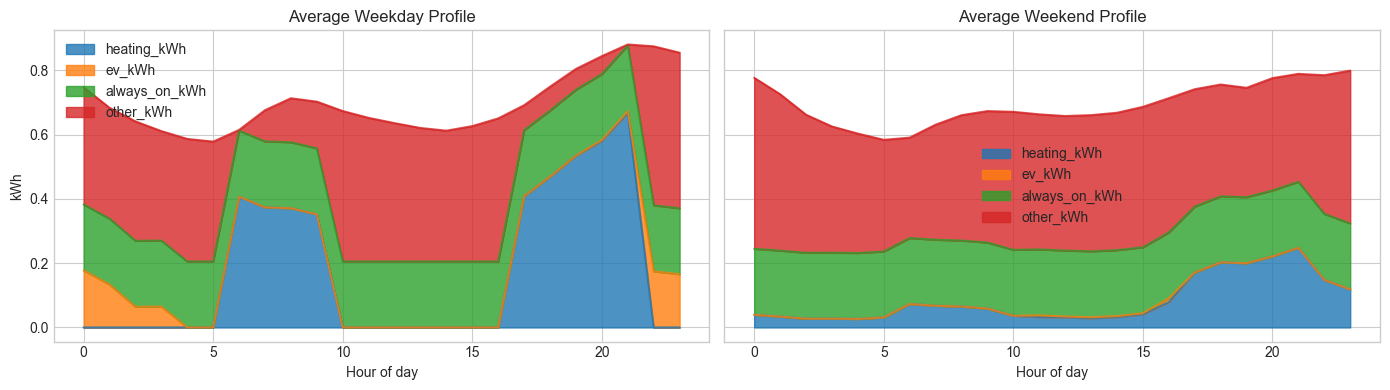

In [17]:
# Extract hour and weekday info
df_vis = submit.copy()
df_vis["household_id"] = df_vis["kaggle_id"].str.split("_").str[0].astype(int)
df_vis["timestamp"] = pd.to_datetime(df_vis["kaggle_id"].str.split("_").str[1])
df_vis["hour"] = df_vis["timestamp"].dt.hour
df_vis["dow"] = df_vis["timestamp"].dt.dayofweek
df_vis["is_weekend"] = df_vis["dow"] >= 5

weekday = df_vis[~df_vis["is_weekend"]].groupby("hour")[["heating_kWh","ev_kWh","always_on_kWh","other_kWh"]].mean()
weekend = df_vis[df_vis["is_weekend"]].groupby("hour")[["heating_kWh","ev_kWh","always_on_kWh","other_kWh"]].mean()

fig, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
weekday.plot.area(ax=ax[0], alpha=0.8)
ax[0].set_title("Average Weekday Profile")
weekend.plot.area(ax=ax[1], alpha=0.8)
ax[1].set_title("Average Weekend Profile")
for a in ax:
    a.set_xlabel("Hour of day")
    a.set_ylabel("kWh")
plt.tight_layout()
plt.show()

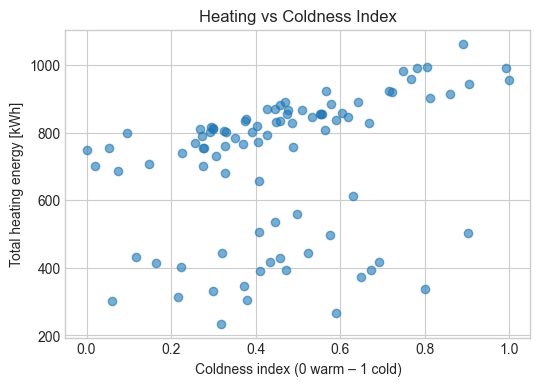

In [18]:
df_vis["date"] = df_vis["timestamp"].dt.date
daily_heating = df_vis.groupby("date")["heating_kWh"].sum()
daily_total = df_vis.groupby("date")[["heating_kWh","ev_kWh","other_kWh"]].sum().sum(axis=1)
coldness = df.groupby("date")["coldness_idx"].first()

plt.figure(figsize=(6,4))
plt.scatter(coldness, daily_heating, alpha=0.6)
plt.xlabel("Coldness index (0 warm – 1 cold)")
plt.ylabel("Total heating energy [kWh]")
plt.title("Heating vs Coldness Index")
plt.show()

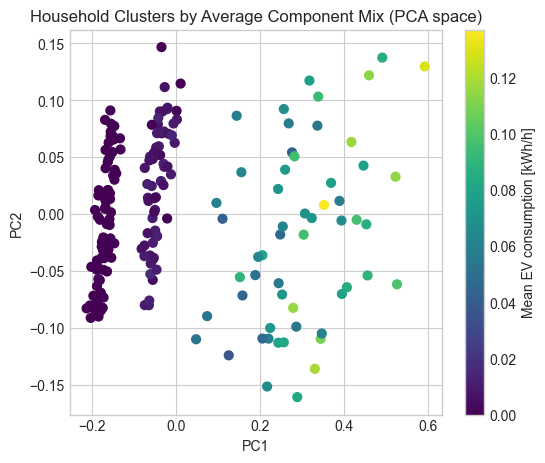

In [19]:
from sklearn.decomposition import PCA
X = df_vis.groupby("household_id")[["heating_kWh","ev_kWh","always_on_kWh","other_kWh"]].mean()
pca = PCA(2)
coords = pca.fit_transform(X)
plt.figure(figsize=(6,5))
plt.scatter(coords[:,0], coords[:,1], c=X["ev_kWh"], cmap="viridis", s=40)
plt.colorbar(label="Mean EV consumption [kWh/h]")
plt.title("Household Clusters by Average Component Mix (PCA space)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

<Axes: xlabel='hour'>

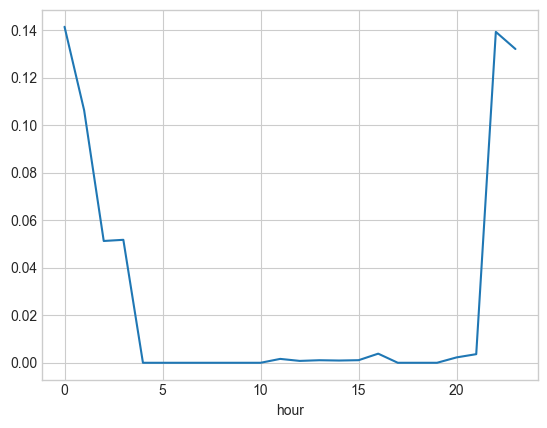

In [20]:
ev_households = df[df["is_ev_owner"]].household_id.unique()
df_vis[df_vis.household_id.isin(ev_households)].groupby("hour")["ev_kWh"].mean().plot()

In [21]:
df

,kaggle_id,household_id,timestamp,consumption_kWh,date,hour,dow,is_weekend,always_on_kWh,residual_kWh,coldness_idx,is_heat_owner,is_ev_owner
0,0_2024-03-01 00,0,2024-03-01 00:00:00,0.2590,2024-03-01,0,4,False,0.090660,0.168340,0.993323,False,True
1,0_2024-03-01 01,0,2024-03-01 01:00:00,0.0648,2024-03-01,1,4,False,0.090660,0.000000,0.993323,False,True
2,0_2024-03-01 02,0,2024-03-01 02:00:00,0.0644,2024-03-01,2,4,False,0.090660,0.000000,0.993323,False,True
3,0_2024-03-01 03,0,2024-03-01 03:00:00,0.0661,2024-03-01,3,4,False,0.090660,0.000000,0.993323,False,True
4,0_2024-03-01 04,0,2024-03-01 04:00:00,0.1306,2024-03-01,4,4,False,0.090660,0.039940,0.993323,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
441595,199_2024-05-31 19,199,2024-05-31 19:00:00,0.1688,2024-05-31,19,4,False,0.073635,0.095165,0.291569,False,True
441596,199_2024-05-31 20,199,2024-05-31 20:00:00,0.1541,2024-05-31,20,4,False,0.073635,0.080465,0.291569,False,True
441597,199_2024-05-31 21,199,2024-05-31 21:00:00,0.0942,2024-05-31,21,4,False,0.073635,0.020565,0.291569,False,True
441598,199_2024-05-31 22,199,2024-05-31 22:00:00,0.0949,2024-05-31,22,4,False,0.073635,0.021265,0.291569,False,True


In [22]:
submit

,kaggle_id,heating_kWh,ev_kWh,always_on_kWh,other_kWh
0,0_2024-03-01 00,0.00000,0.0,0.09066,0.16834
1,0_2024-03-01 01,0.00000,0.0,0.09066,0.00000
2,0_2024-03-01 02,0.00000,0.0,0.09066,0.00000
3,0_2024-03-01 03,0.00000,0.0,0.09066,0.00000
4,0_2024-03-01 04,0.00000,0.0,0.09066,0.03994
...,...,...,...,...,...
441595,9_2024-05-31 19,0.43932,0.0,0.15388,0.00000
441596,9_2024-05-31 20,0.41652,0.0,0.15388,0.00000
441597,9_2024-05-31 21,0.73822,0.0,0.15388,0.00000
441598,9_2024-05-31 22,0.00000,0.0,0.15388,0.75562


In [23]:
# Aggregate daily energy per component
daily_energy = (
    submit.copy()
    .assign(
        timestamp=lambda x: pd.to_datetime(x["kaggle_id"].str.split("_").str[1])
    )
    .groupby(["timestamp"])[["heating_kWh","ev_kWh","always_on_kWh","other_kWh"]].sum()
)

daily_energy["dow"] = daily_energy.index.dayofweek
daily_energy["is_weekend"] = daily_energy["dow"] >= 5

# Compute mean weekday vs weekend totals
weekday_mean = daily_energy[~daily_energy["is_weekend"]].mean(numeric_only=True)
weekend_mean = daily_energy[daily_energy["is_weekend"]].mean(numeric_only=True)

ratio = (weekend_mean / weekday_mean).rename("weekend/weekday ratio")
ratio

heating_kWh      0.489249
ev_kWh           0.037916
always_on_kWh    1.000000
other_kWh        1.409547
dow              2.708955
is_weekend            inf
Name: weekend/weekday ratio, dtype: float64

In [24]:
# Rename submit columns before merging
submit_renamed = submit.rename(columns={
    "heating_kWh": "pred_heating",
    "ev_kWh": "pred_ev",
    "always_on_kWh": "pred_always_on",
    "other_kWh": "pred_other"
})

# Merge
df_pred = df.merge(submit_renamed, on="kaggle_id")

# Compute reconstructed and residuals
df_pred["reconstructed"] = df_pred[["pred_heating","pred_ev","pred_always_on","pred_other"]].sum(axis=1)
df_pred["residual"] = df_pred["consumption_kWh"] - df_pred["reconstructed"]

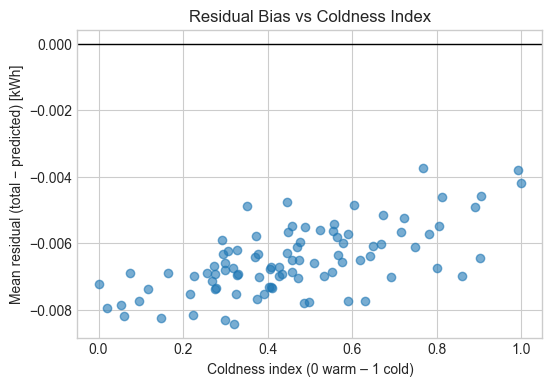

Correlation between residual and coldness index: 0.644


In [25]:
# ==========================================================
# (b) Validation: Residual bias vs Coldness Index
# ==========================================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. Rename prediction columns to avoid merge suffixes
submit_renamed = submit.rename(columns={
    "heating_kWh": "pred_heating",
    "ev_kWh": "pred_ev",
    "always_on_kWh": "pred_always_on",
    "other_kWh": "pred_other"
})

# --- 2. Merge actual + predictions
df_pred = df.merge(submit_renamed, on="kaggle_id", how="left")

# --- 3. Compute reconstructed total and residual
df_pred["reconstructed"] = (
    df_pred[["pred_heating","pred_ev","pred_always_on","pred_other"]].sum(axis=1)
)
df_pred["residual"] = df_pred["consumption_kWh"] - df_pred["reconstructed"]

# --- 4. Daily mean residual vs coldness index
daily_resid = (
    df_pred.groupby("date")[["residual"]].mean()
    .merge(df.groupby("date")[["coldness_idx"]].first(),
           left_index=True, right_index=True)
)

# --- 5. Plot residual bias vs coldness
plt.figure(figsize=(6,4))
plt.scatter(daily_resid["coldness_idx"], daily_resid["residual"], alpha=0.6)
plt.axhline(0, color="black", lw=1)
plt.xlabel("Coldness index (0 warm – 1 cold)")
plt.ylabel("Mean residual (total − predicted) [kWh]")
plt.title("Residual Bias vs Coldness Index")
plt.show()

# --- 6. Optional correlation check
corr = np.corrcoef(daily_resid["coldness_idx"], daily_resid["residual"])[0,1]
print(f"Correlation between residual and coldness index: {corr:.3f}")

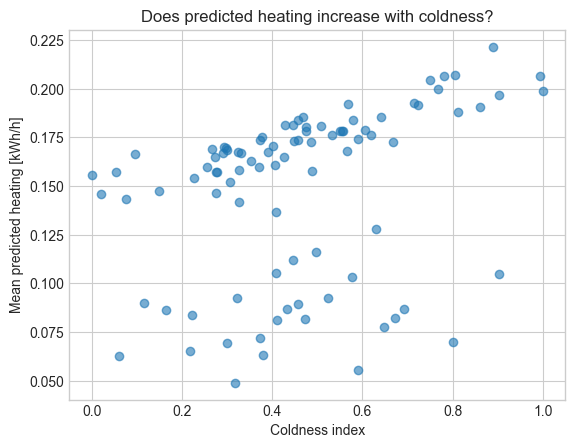

In [26]:
test = df_pred.groupby("date")[["pred_heating","pred_ev","pred_other","coldness_idx"]].mean()
plt.scatter(test["coldness_idx"], test["pred_heating"], alpha=0.6)
plt.xlabel("Coldness index")
plt.ylabel("Mean predicted heating [kWh/h]")
plt.title("Does predicted heating increase with coldness?")
plt.show()

In [27]:
cold_day = df.groupby("date")["coldness_idx"].idxmax()
warm_day = df.groupby("date")["coldness_idx"].idxmin()

Warm day: 2024-05-08, Cold day: 2024-03-07
Household 163


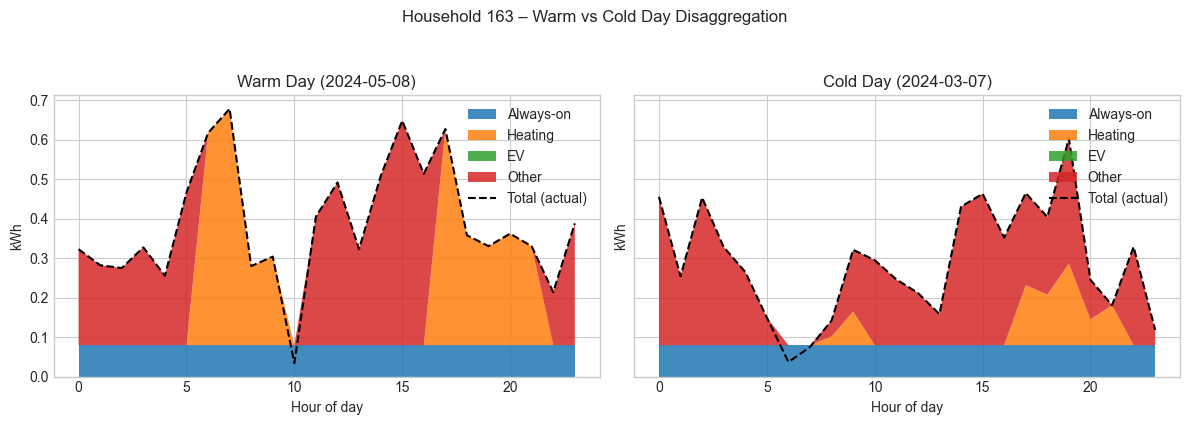

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Identify coldest and warmest days (based on system coldness index)
cold_day = df.groupby("date")["coldness_idx"].mean().idxmax()
warm_day = df.groupby("date")["coldness_idx"].mean().idxmin()

print(f"Warm day: {warm_day}, Cold day: {cold_day}")

# --- 2. Pick a sample household (change ID if you want)
household_id = np.random.choice(df["household_id"].unique())
print(f"Household {household_id}")

# --- 3. Merge predictions if not already done
submit_renamed = submit.rename(columns={
    "heating_kWh": "pred_heating",
    "ev_kWh": "pred_ev",
    "always_on_kWh": "pred_always_on",
    "other_kWh": "pred_other"
})
df_vis = df.merge(submit_renamed, on="kaggle_id", how="left")

# --- 4. Select data for chosen household and days
hh_cold = df_vis[(df_vis["household_id"] == household_id) & (df_vis["date"] == cold_day)].copy()
hh_warm = df_vis[(df_vis["household_id"] == household_id) & (df_vis["date"] == warm_day)].copy()

# --- 5. Sort by hour and reconstruct total
for hh in [hh_cold, hh_warm]:
    hh.sort_values("hour", inplace=True)
    hh["pred_total"] = hh[["pred_heating","pred_ev","pred_always_on","pred_other"]].sum(axis=1)

# --- 6. Plot side by side
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)

for i, (day_df, label) in enumerate(zip([hh_warm, hh_cold], ["Warm Day", "Cold Day"])):
    ax[i].stackplot(
        day_df["hour"],
        day_df["pred_always_on"],
        day_df["pred_heating"],
        day_df["pred_ev"],
        day_df["pred_other"],
        labels=["Always-on", "Heating", "EV", "Other"],
        alpha=0.85
    )
    ax[i].plot(day_df["hour"], day_df["consumption_kWh"], "k--", lw=1.5, label="Total (actual)")
    ax[i].set_title(f"{label} ({day_df['date'].iloc[0]})")
    ax[i].set_xlabel("Hour of day")
    ax[i].set_ylabel("kWh")
    ax[i].legend(loc="upper right")

plt.suptitle(f"Household {household_id} – Warm vs Cold Day Disaggregation", y=1.05)
plt.tight_layout()
plt.show()

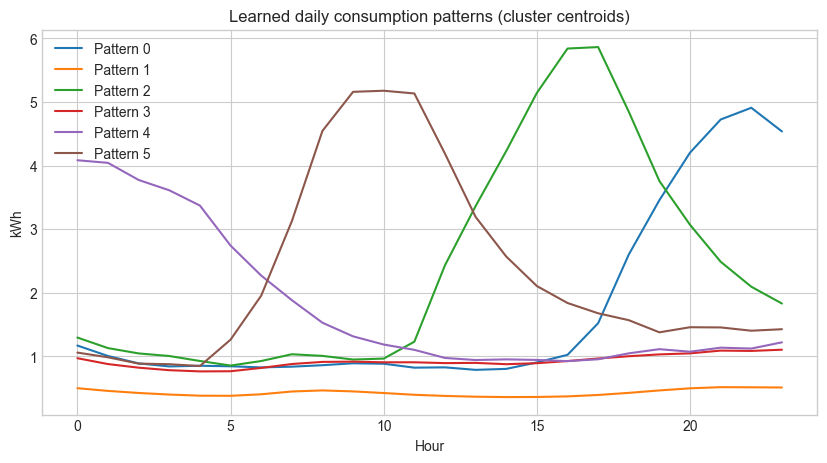

   cluster     night       day   evening  peak_hour
0        0  0.932315  0.836559  4.072312         22
1        1  0.421702  0.378716  0.486102         21
2        2  1.041826  2.893588  3.014051         17
3        3  0.828973  0.894137  1.058763         23
4        4  3.604172  1.015538  1.117521          0
5        5  0.984711  3.727766  1.447094         10
Cluster mapping: always_on=1, heating=2, EV=0, other=3
Saved submission_data_driven_nnls.csv


In [29]:
# ============================================================
# New Pipeline: Data-driven Dictionary Disaggregation (NNLS)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.optimize import nnls
import matplotlib.pyplot as plt

# --- 1. Load and prepare data
df = pd.read_csv("kaggle_clustering_student_version.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = df["timestamp"].dt.date
df["hour"] = df["timestamp"].dt.hour
df["dow"] = df["timestamp"].dt.dayofweek
df["is_weekend"] = df["dow"] >= 5

# --- 2. Compute household daily profiles (24-hour vectors)
daily_profiles = (
    df.groupby(["household_id", "date"])["consumption_kWh"]
      .apply(lambda x: x.values if len(x)==24 else np.full(24, np.nan))
      .dropna()
)
profiles = np.stack(daily_profiles.values)
house_ids = [idx[0] for idx in daily_profiles.index]
dates = [idx[1] for idx in daily_profiles.index]

# --- 3. Cluster days into typical behavior groups (weekday vs weekend)
# Flatten across households; KMeans finds recurring shapes
n_clusters = 6  # a good start: 6 archetypes across all days
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
labels = kmeans.fit_predict(profiles)
centroids = kmeans.cluster_centers_  # (6 x 24)

# Optional: visualize learned patterns
plt.figure(figsize=(10,5))
for i, c in enumerate(centroids):
    plt.plot(range(24), c, label=f'Pattern {i}')
plt.legend(); plt.title("Learned daily consumption patterns (cluster centroids)")
plt.xlabel("Hour"); plt.ylabel("kWh")
plt.show()

# --- 4. Classify archetypes into semantic categories
# We can heuristically map clusters to [always-on, heating, EV, other]
# based on shape features (morning/evening peaks, night spikes, etc.)
# Compute basic features for mapping
cluster_stats = []
for i, c in enumerate(centroids):
    night_mean = np.mean(c[[0,1,2,3,4,5]])
    day_mean = np.mean(c[[10,11,12,13,14,15]])
    eve_mean = np.mean(c[[18,19,20,21,22,23]])
    cluster_stats.append((i, night_mean, day_mean, eve_mean, np.argmax(c)))
cluster_df = pd.DataFrame(cluster_stats, columns=["cluster","night","day","evening","peak_hour"])
print(cluster_df)

# Rough mapping:
# - Always-on = flat cluster (low std)
# - EV = evening peak (after 20)
# - Heating = double peak (morning+evening)
# - Other = single daytime or mild evening
stds = centroids.std(axis=1)
flat_idx = np.argmin(stds)
ev_idx = np.argmax([c[20:].mean() - c[:10].mean() for c in centroids])
heat_idx = np.argmax([c[6:9].mean() + c[17:21].mean() for c in centroids])
other_idx = list(set(range(n_clusters)) - {flat_idx, ev_idx, heat_idx})[0]

print(f"Cluster mapping: always_on={flat_idx}, heating={heat_idx}, EV={ev_idx}, other={other_idx}")

# --- 5. Use these 4 archetypes as dictionary components
A = np.vstack([
    centroids[flat_idx],
    centroids[heat_idx],
    centroids[ev_idx],
    centroids[other_idx]
]).T  # shape (24, 4)

# Normalize each component to unit sum
A = A / A.sum(axis=0, keepdims=True)

# --- 6. Fit each household-day with NNLS to these 4 basis profiles
results = []
for i, (hid, day) in enumerate(zip(house_ids, dates)):
    y = profiles[i]
    if np.any(np.isnan(y)):
        continue
    coeffs, _ = nnls(A, y)
    recon = A @ coeffs
    # scale small numerical errors
    if np.any(recon > 0):
        recon *= y.sum() / recon.sum()
    components = A * coeffs
    results.append({
        "household_id": hid,
        "date": day,
        "coeffs": coeffs,
        "heating": components[:,1],
        "ev": components[:,2],
        "always_on": components[:,0],
        "other": components[:,3]
    })

# --- 7. Reconstruct full hourly predictions
rows = []
for r in results:
    for h in range(24):
        kaggle_id = f"{r['household_id']}_{r['date']} {h:02d}"
        rows.append({
            "kaggle_id": kaggle_id,
            "heating_kWh": r["heating"][h],
            "ev_kWh": r["ev"][h],
            "always_on_kWh": r["always_on"][h],
            "other_kWh": r["other"][h],
        })
submit = pd.DataFrame(rows)

# --- 8. Safety normalization per hour (sum to total)
df["kaggle_id"] = df["household_id"].astype(str) + "_" + df["timestamp"].dt.strftime("%Y-%m-%d %H")
merged = df.merge(submit, on="kaggle_id", how="left")
pred_sum = merged[["heating_kWh","ev_kWh","always_on_kWh","other_kWh"]].sum(axis=1)
scale = np.divide(merged["consumption_kWh"], pred_sum, out=np.ones_like(pred_sum), where=pred_sum>1e-9)
for col in ["heating_kWh","ev_kWh","always_on_kWh","other_kWh"]:
    merged[col] = merged[col] * scale
submit = merged[["kaggle_id","heating_kWh","ev_kWh","always_on_kWh","other_kWh"]]

# --- 9. Export for submission
submit.to_csv("submission_data_driven_nnls.csv", index=False)
print("Saved submission_data_driven_nnls.csv")